In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_ic, ridge_regression,\
    kalman_filter, kalman_with_selection
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'HFRXGL'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEWC,HFRX Equal Weighted Strategies CHF Index


In [4]:
pd.options.display.max_rows = 76
pd.read_csv(r"financial_data/bnp_index_info.csv", index_col=0)

,Name,Asset Class,Underlying,Currency,Execution Costs (bps),Replication Costs (bps)
Ticker,,,,,,
BNPIFEU,Eurozone Equity,Equity,Eurostoxx 50,EUR,3,12
BNPIFUS,US Equity,Equity,S&P 500,USD,3,12
BNPIFJP,Japan Equity,Equity,Nikkei,JPY,3,12
BNPIFCN,China Equity,Equity,HSCEI,HKD,3,12
BNPIFFR,France Equity,Equity,CAC 40,EUR,3,12
BNPIFGE,Germany Equity,Equity,Dax,EUR,3,12
BNPIFGB,Great Britain Equity,Equity,FTSE 100,GBP,3,12
BNPIFCH,Swiss Equity,Equity,SMI,CHF,3,12
BNPIFKR,Korea Equity,Equity,Kospi,KRW,3,12


In [5]:
pd.read_csv(r"financial_data/bnp_risk_premia_info.csv", index_col=0)

,Name,Asset class,Style,Return Type,Currency
Ticker,,,,,
BNPIDRXA,BNP Paribas DR Alpha ex-Agriculture and Livest...,Commodities,Carry,ER,EUR
BNPIF3AX,BNP Paribas Alpha Backwardation ex-Agriculture...,Commodities,Carry,ER,EUR
BNPIF3XM,BNP Paribas Alpha Momentum ex-Agriculture and ...,Commodities,Momentum,ER,EUR
BPFXSTGU,BNP Paribas 1M STEER Index,FX,Value,ER,EUR
BNPICCE3,BNP Paribas 103 Call Carry Excess Return Index,Equity,Carry,ER,EUR
BNPIVMRU,BNP Paribas Volatility Mean Reversion US,Equity,Reversal,ER,EUR
BPCURVW4,BNP Paribas Money Market Beta World Index,IR,Carry,ER,EUR
BNPIVCXA,BNP Paribas Commodity Short Variance VCXA ER I...,Commodities,Short Variance,ER,EUR
BNPIAIRT,BNP Paribas AIR T-Note ER Index,Equity,Volatility,ER,EUR


### Financial data loads and cleaning

In [6]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True) #[["BNPIFEU","BNPIFUS",
                 #"BNPIFJP","BNPIFCN","BNPIFFR","BNPIFGE","BNPIFGB","BNPIFCH","BNPIFKR","BNPIFUSC","BNPIFBR",
                 #"BNPIFAU","BNPIFHK","BNPIFTW","BNPIFSG","BNPIFIT","BNPIFSP","BNPIFSW","BNPIFNE","BNPIFRU","BNPIFEM"]]

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl") #[["BNPICCE3","BNPIVMRU","BNPIAIRT","BNPIAIRU",
                  #"BNPIEC03","BNPIPLEE","BNPIPMEE","BNPIPQEE","BNPIPVEE","BNPILUEE","BNPIPMUH","BNPIPQUH",
                  #"BNPIPVUH","BNPIAIRG","BNPIAIRJ","BNPIAIRE"]]

In [7]:
prices_all = bnp.join(risk_premia,how="outer").ffill().join(hfrx,how="inner")

In [8]:
returns_all = prices_all.resample('1D').first().pct_change().dropna()
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)

In [9]:
alpha = hrfx_returns[fund_name].autocorr(lag=1)
hrfx_returns_adj = ((hrfx_returns - alpha * hrfx_returns.shift(1)) / (1. - alpha)).fillna(0) # 'liquidity adjustment' for
                                                                                             # removing returns autocorrelation
beta = hrfx_returns_adj[fund_name].autocorr(lag=1)

Auto-correlation of HFRXGL returns : 0.213566157327
Auto-correlation of HFRXGL adjusted returns : -0.00499205508603


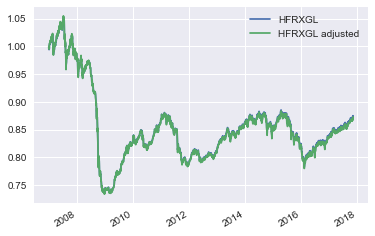

In [10]:
print("Auto-correlation of",fund_name,"returns :", alpha)
print("Auto-correlation of",fund_name,"adjusted returns :", beta)
ax = (1 + hrfx_returns).cumprod().plot()
_ = (1 + hrfx_returns_adj).cumprod()[fund_name].plot(label=fund_name + ' adjusted', legend=True, ax=ax)

In [11]:
size = 126
freq = 5

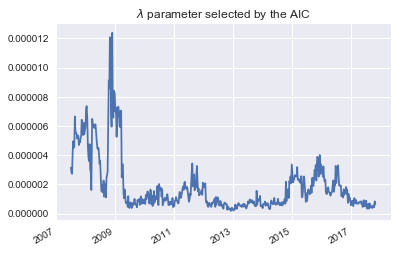

Wall time: 40.5 s


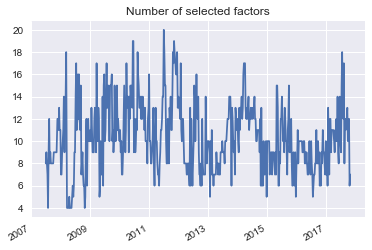

In [12]:
%%time
df_weight_aic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='aic')
prices_for_track_aic = prices_all.loc[df_weight_aic.index[0]:].drop(fund_name, axis=1)

(df_weight_aic != 0).sum(axis=1).plot(title='Number of selected factors')

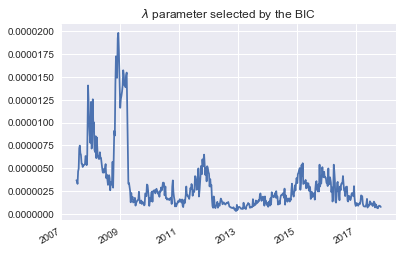

Wall time: 36.4 s


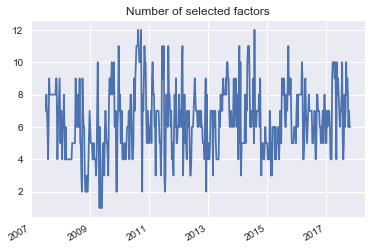

In [13]:
%%time
df_weight_bic, _ = lasso_regression_ic(hrfx_returns, returns_all,sample_length=size, frequency=freq, criterion='bic')
prices_for_track_bic = prices_all.loc[df_weight_bic.index[0]:].drop(fund_name, axis=1)

(df_weight_bic != 0).sum(axis=1).plot(title='Number of selected factors')

In [14]:
%%time
nu = 1.
df_weight_kalman = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu)

prices_for_track_kalman = prices_all.loc[df_weight_kalman.index[0]:]

Wall time: 1.95 s


In [15]:
%%time
nb_period = 120
df_weight_kalman_bic = kalman_with_selection(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, nb_period=nb_period, criterion='bic')

prices_for_track_kalman_bic = prices_all.loc[df_weight_kalman_bic.index[0]:]

Wall time: 3min 18s


In [16]:
%%time
df_weight_kalman_aic = kalman_with_selection(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, nb_period=nb_period, criterion='aic')

prices_for_track_kalman_aic = prices_all.loc[df_weight_kalman_aic.index[0]:]

Wall time: 3min 15s


In [135]:
tc = 0.0003
lag = 1

replication_aic = make_track(prices_for_track_aic, df_weight_aic, tc=tc, lag=lag)
df_res = prices_all.loc[replication_aic.index][[fund_name]]
df_res["Lasso AIC"] = replication_aic

replication_bic = make_track(prices_for_track_bic, df_weight_bic, tc=tc, lag=lag)
df_res["Lasso BIC"] = replication_bic

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman"] = replication_kalman

replication_kalman_aic = make_track(prices_for_track_kalman_aic, df_weight_kalman_aic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman AIC"] = replication_kalman_aic

replication_kalman_bic = make_track(prices_for_track_kalman_bic, df_weight_kalman_bic, tc=tc, lag=lag).loc[df_res.index[0]:]
df_res["Kalman BIC"] = replication_kalman_bic

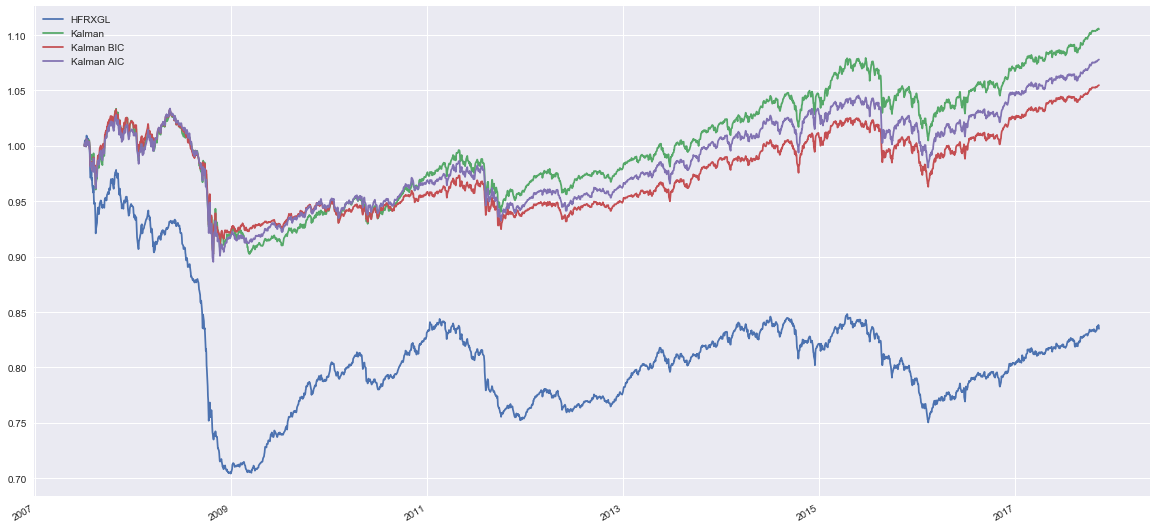

In [136]:
df_res = (df_res / df_res.iloc[0])
df_res[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

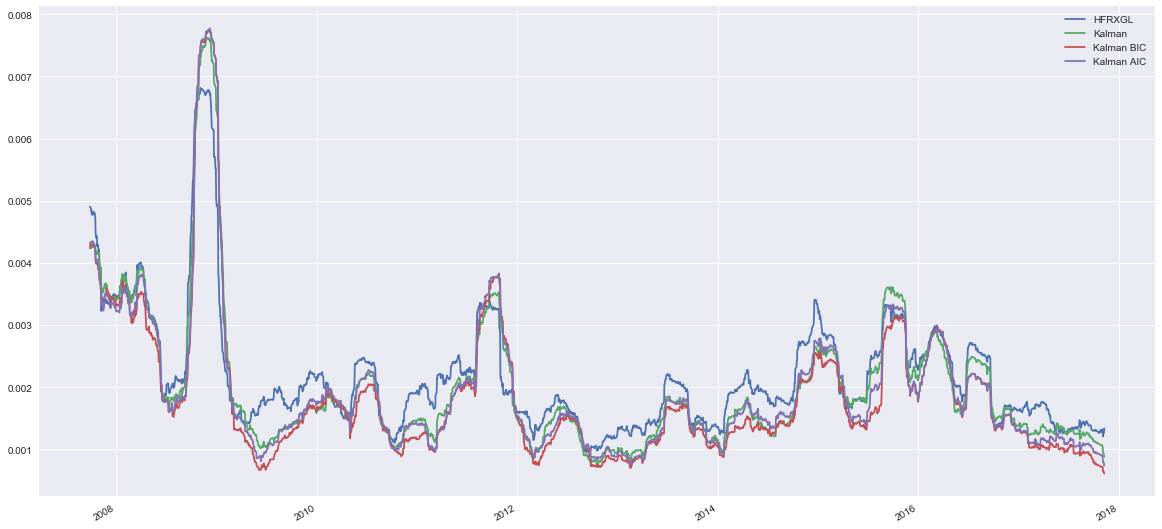

In [137]:
vol = df_res.pct_change().rolling(window=60).std().dropna()
vol[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

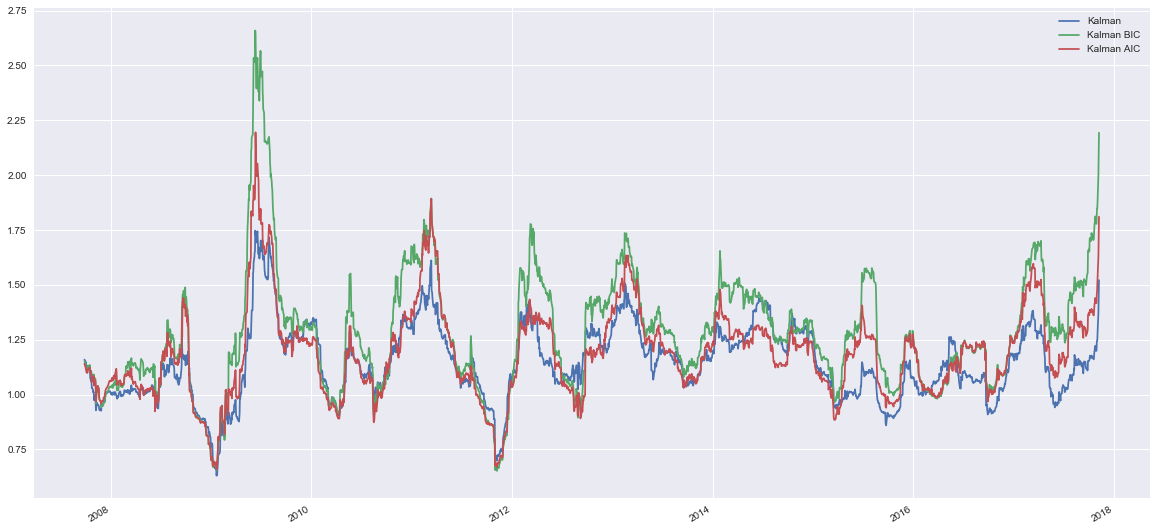

In [138]:
vol_fund = vol[fund_name]
vol_ratio = 1. / vol.div(vol_fund, axis='index').drop(fund_name, axis=1)
vol_ratio[['Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [139]:
prices_for_track_all = prices_for_track_aic[df_weight_aic.multiply(vol_ratio['Lasso AIC'], axis='index').dropna().index[0]:]

replication_aic_voladj = make_track(prices_for_track_all, df_weight_aic.multiply(vol_ratio['Lasso AIC'], axis='index').dropna(), tc=tc, lag=lag)
df_res_voladj = prices_all.loc[replication_aic_voladj.index][[fund_name]]
df_res_voladj["Lasso AIC"] = replication_aic_voladj

replication_bic_voladj = make_track(prices_for_track_all, df_weight_bic.multiply(vol_ratio['Lasso BIC'], axis='index').dropna(), tc=tc, lag=lag)
df_res_voladj["Lasso BIC"] = replication_bic_voladj

prices_for_track_all = prices_for_track_kalman[df_weight_kalman.multiply(vol_ratio['Kalman'], axis='index').dropna().index[0]:]

replication_kalman_voladj = make_track(prices_for_track_all, df_weight_kalman.multiply(vol_ratio['Kalman'], axis='index').dropna(), tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman"] = replication_kalman_voladj

prices_for_track_all = prices_for_track_kalman_aic[df_weight_kalman_aic.multiply(vol_ratio['Kalman AIC'], axis='index').dropna().index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track_all, df_weight_kalman_aic.multiply(vol_ratio['Kalman AIC'], axis='index').dropna(), tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman AIC"] = replication_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track_all, df_weight_kalman_bic.multiply(vol_ratio['Kalman BIC'], axis='index').dropna(), tc=tc, lag=lag).loc[df_res_voladj.index[0]:]
df_res_voladj["Kalman BIC"] = replication_kalman_bic_voladj

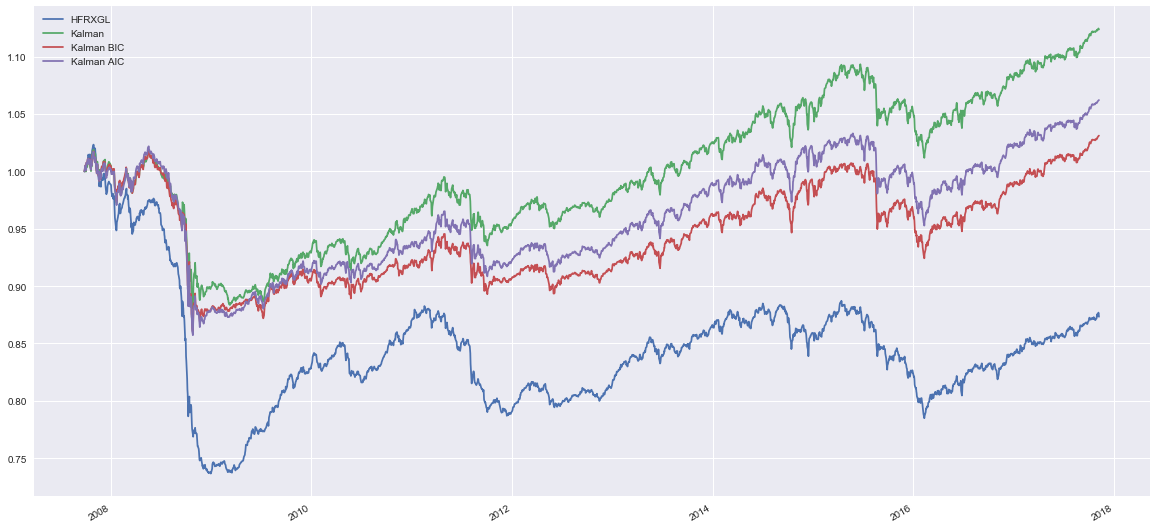

In [140]:
df_res_voladj = df_res_voladj.bfill()
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

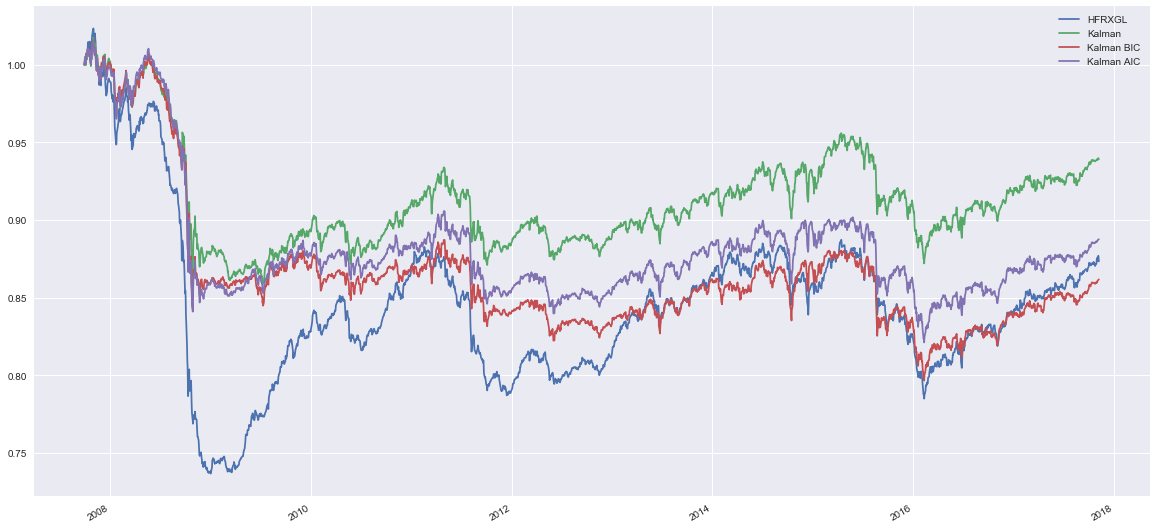

In [143]:
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 1.75 + 0 * US_rate)
df_res_volperfadj[[fund_name, 'Kalman', 'Kalman BIC', 'Kalman AIC']].plot(figsize=(20,10))

In [23]:
rho = df_res.pct_change().corr(method="pearson")
tau = df_res.pct_change().corr(method="kendall")

In [142]:
returns_track = df_res_voladj.pct_change().dropna()
fund = returns_track[fund_name]
returns_track = returns_track
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - fund.values).std(axis=1)
df['R-squared'] = 1 - (returns_track.T - fund.values).var(axis=1) / fund.values.var()
df['Sharpe ratio'] = np.sqrt(252) * returns_track.mean() / returns_track.std()
df['Annual Return'] =  (df_res.iloc[-1] / df_res.iloc[0]) ** (252 / len(df_res.index)) - 1
df['Correlation'] = rho[fund_name]
df['Kendall tau'] = tau[fund_name]
df

,Tracking error,R-squared,Sharpe ratio,Annual Return,Correlation,Kendall tau
HFRXGL,0.000000,1.000000,-0.332689,-0.0172689,1.000000,1.000000
Lasso AIC,0.001492,0.613005,0.195856,0.00831886,0.812568,0.606648
Lasso BIC,0.001629,0.538397,0.105200,0.00510377,0.790900,0.588198
Kalman,0.001376,0.670786,0.311708,0.00971493,0.839783,0.628085
Kalman AIC,0.001494,0.611643,0.164107,0.00726931,0.823847,0.612640
Kalman BIC,0.001566,0.573725,0.093147,0.00516095,0.809802,0.599138


In [ ]:
(df_weight_aic).mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
(df_weight_bic).mean(axis=0).plot(kind='barh', figsize=(15,20))

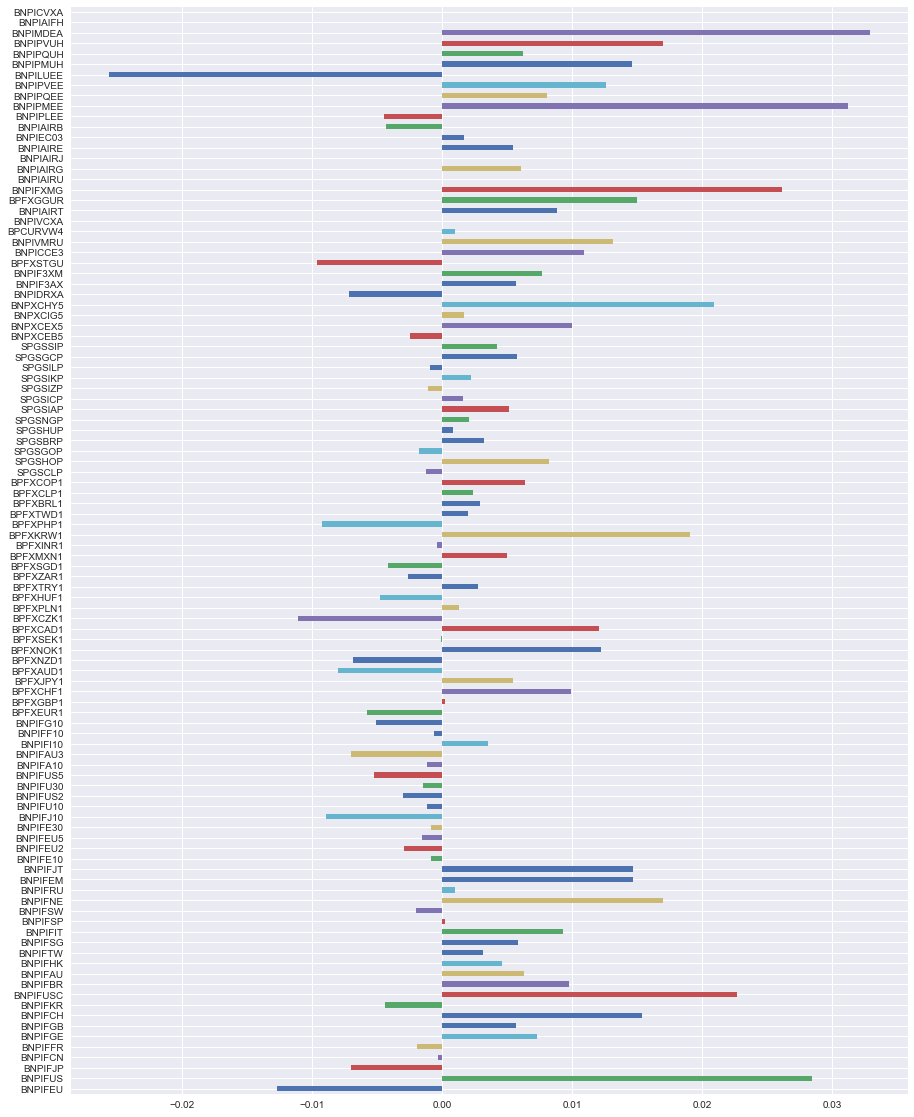

In [133]:
df_weight_kalman.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

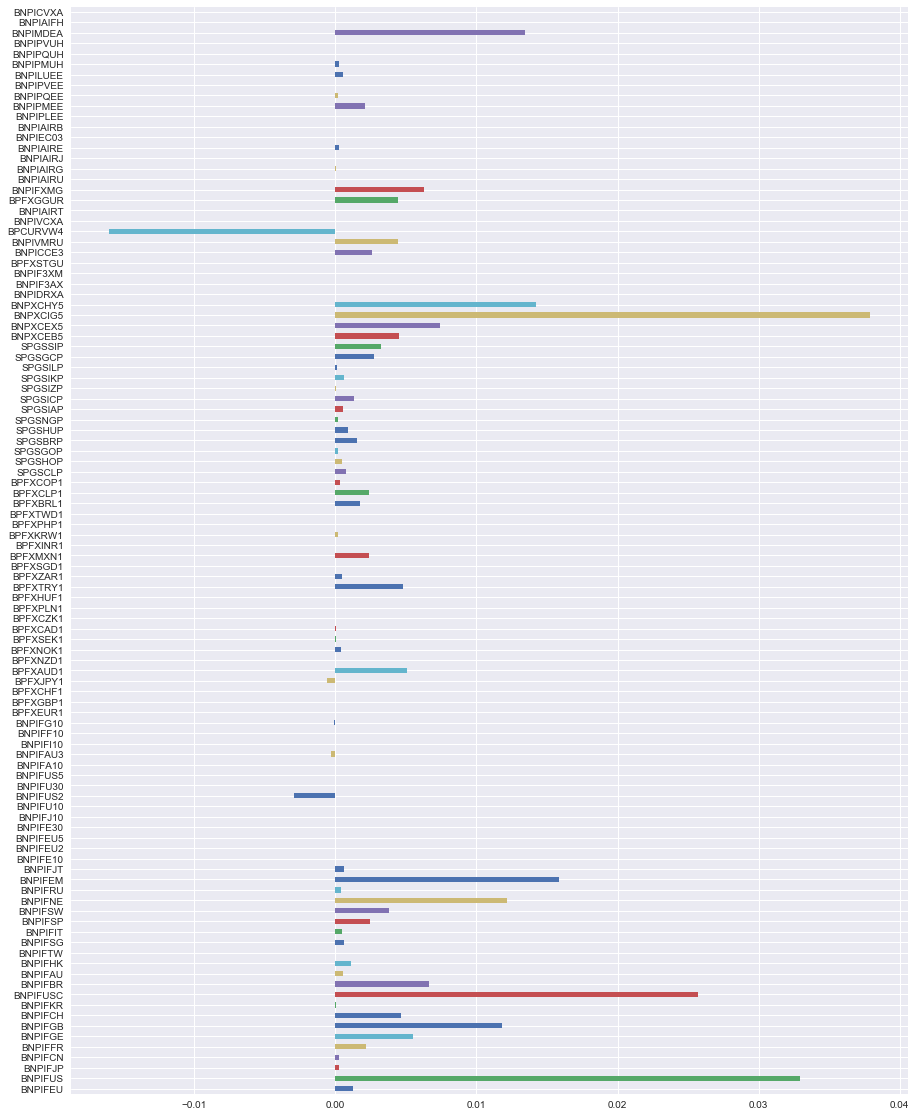

In [134]:
df_weight_kalman_bic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
df_weight_kalman_aic.loc[df_res.index[0]:].mean(axis=0).plot(kind='barh', figsize=(15,20))

In [ ]:
df_res[fund_name].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman BIC'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Kalman AIC'].pct_change().autocorr(lag=1)

In [ ]:
df_res['Lasso AIC'].pct_change().autocorr(lag=1)